# Consider heterogeneous household epidemics

Code to look at household data as it relates to susceptibility heterogeneity. Apply to some of the data from Dattner (2021) using ABC. First, check conventions.

From https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html, we have that the pdf of a gamma distribution is
$$
f(x|a) = \frac{x^{a-1} \mathrm{e}^{-x}}{\Gamma(a)} \, ,
$$
and that setting $\mathtt{scale} = 1/\beta$ gives 
$$
f(x|a, \beta) = \frac{\beta^a x^{a-1} \mathrm{e}^{-\beta x}}{\Gamma(a)} \, .
$$
In Wood et al., we have
$$
f(x|\nu, k) = \frac{\nu^k x^{k-1} \mathrm{e}^{-\alpha x}}{\Gamma(k)} \, .
$$
This means that Wood et al.'s $\nu$ and $k$ are Python's $\beta$ and $a$ respectively. Wood et al. quote values for the 'immunity coefficient' $\lambda = 1 + (1/k)$, with explicit values of $1.2$, $2.9$ and $4.7$ quoted. So we have
$$
a = k = \frac{1}{\lambda - 1} \, , \qquad \mathtt{scale} = \frac{1}{\beta} = \frac{1}{\nu} \, .
$$
The mean of the Gamma distribution is $\mu = a / \beta = 1/(\nu(\lambda-1))$. So if we put a prior on $\mu$ and sample from that across scenarios, we will get $\nu$ from
$$
\nu = \frac{1}{\mu(\lambda -1)} \, .
$$

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from io import StringIO

In [3]:
dattner = StringIO(""",0,1,2,3,4,5,6,7,8,9
1,85,73,NA,NA,NA,NA,NA,NA,NA,NA
2,46,21,19,NA,NA,NA,NA,NA,NA,NA
3,38,13,9,8,NA,NA,NA,NA,NA,NA
4,24,19,11,8,1,NA,NA,NA,NA,NA
5,25,15,12,7,3,2,NA,NA,NA,NA
6,13,19,3,5,3,5,5,NA,NA,NA
7,5,6,5,7,4,4,4,0,NA,NA
8,10,7,3,4,0,3,3,4,0,NA
9,6,3,4,6,4,1,2,2,2,0
""")

In [4]:
df = pd.read_csv(
  dattner,
  sep=",",
  )
X = df.values[:,1:]

We consider a model in which each individual $i$ in a household picks a susceptibility $\alpha_i \sim \mathrm{Gamma}(\nu,k)$ and becomes infected at rate $\alpha_i I(t)$, where $I(t)$ is the number of infective individuals in the household at time $i$, with infected individuals recovering after an $\mathrm{Exp}(1)$ distributed period of time. This is equivalent to a Sellke construction in which each individual picks a resistance $Q_i \sim \mathrm{Exp}(\alpha_i)$, then becomes infective when $\int_{0}^{t} I(\tau) \mathrm{d}\tau =: \Lambda(t) > Q_i$. To see why the equivalence holds, note that
$$
\mathrm{Pr}(Q_i > \Lambda(t+\delta t) | Q_i > \Lambda(t+\delta t)) = \frac{\exp(-\alpha_i \Lambda(t+\delta t))}{\exp(-\alpha_i \Lambda(t))} = 1 - \alpha_i I(t) + o(\delta t) \, .
$$
We can then obtain samples from the final size without full representation of the temporal dynamics in the standard manner.


In [5]:
def get_fs(nu, lam, n, m):
    # For m households of size n+1 (meaning max n secondaries)
    y = np.zeros(m,dtype=int)
    gd = st.gamma(a=1/(lam-1), scale=1/nu)
    for i in range(0,m):
        Qvec = np.sort(np.atleast_1d(st.expon.rvs(scale=1/gd.rvs(size=(n)))))
        Lam = st.expon.rvs()
        while(Lam > Qvec[y[i]]):
            y[i] += 1
            Lam += st.expon.rvs()
            if(y[i]==n):
                break
    return(y)

In [6]:
def get_D(nu, la):
    D = 0
    for i in range(1,5):
        n = i+2
        yy = X[i,0:n]
        m = int(np.sum(yy))
        fs = get_fs(nu,la,n-1,m)
        zz = np.bincount(fs,minlength=(n))
        D += 0.5*np.sum(np.abs(zz-yy)) # Total Variation for discrete
    return(D)

In [7]:
lavec = np.array([1.2, 2.9, 4.7])
mulow = 0.0
muhigh = 2.0
M = 10000 # Number of ABC samples to take

In [8]:
Dvec = np.zeros((M,3))
muvec = np.zeros((M,3))
nuvec = np.zeros((M,3))
for i in tqdm(range(0,3)):
    for j in tqdm(range(0,M)):
        muvec[j,i] = np.random.uniform(low=mulow, high=muhigh)
        nuvec[j,i] = 1/(muvec[j,i]*(lavec[i]-1))
        Dvec[j,i] = get_D(nuvec[j,i],la=lavec[i]) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

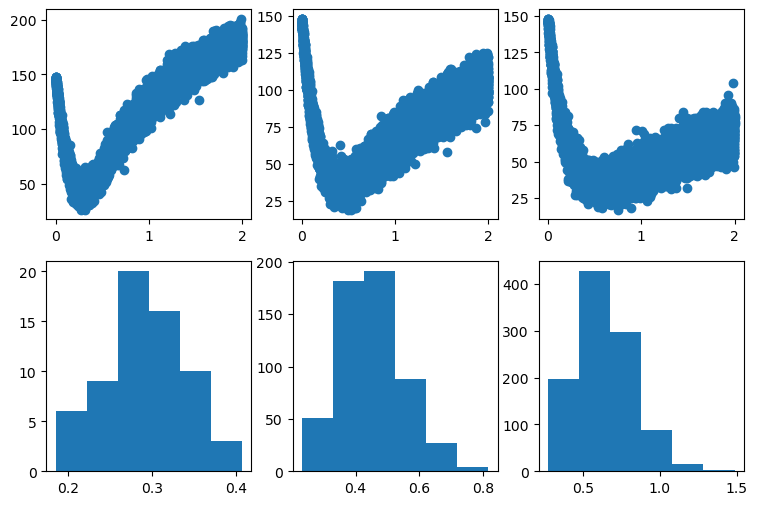

In [30]:
kk = []
plt.figure(figsize=(9,6))
for i in range(0,3):
    plt.subplot(2,3,i+1)
    plt.scatter(muvec[:,i],Dvec[:,i])
    plt.subplot(2,3,i+4)
    kk.append(Dvec[:,i]<35)
    plt.hist(muvec[kk[i],i],6)

In [32]:
[sum(k) for k in kk]

[64, 543, 1028]

In [34]:
Zl = np.zeros((3,9,10))
Zu = np.zeros((3,9,10))
Zm = np.zeros((3,9,10))

In [36]:
for i in tqdm(range(1,5)):
    n = i+2
    xx = np.arange(0,n)
    yy = X[i,0:n] 
    m = int(np.sum(yy))
    for j in range(0,3):
        K = sum(kk[j])
        zz = np.zeros((K,n))
        for l, nu in enumerate(nuvec[kk[j],j]):
            fs = get_fs(nu,lavec[j],n-1,m)
            zz[l,:] = np.bincount(fs,minlength=(n))
        Zl[j,i,0:n] = np.percentile(zz,2.5,0)
        Zu[j,i,0:n] = np.percentile(zz,97.5,0)
        Zm[j,i,0:n] = np.percentile(zz,50,0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
cols = ['k','g','r']

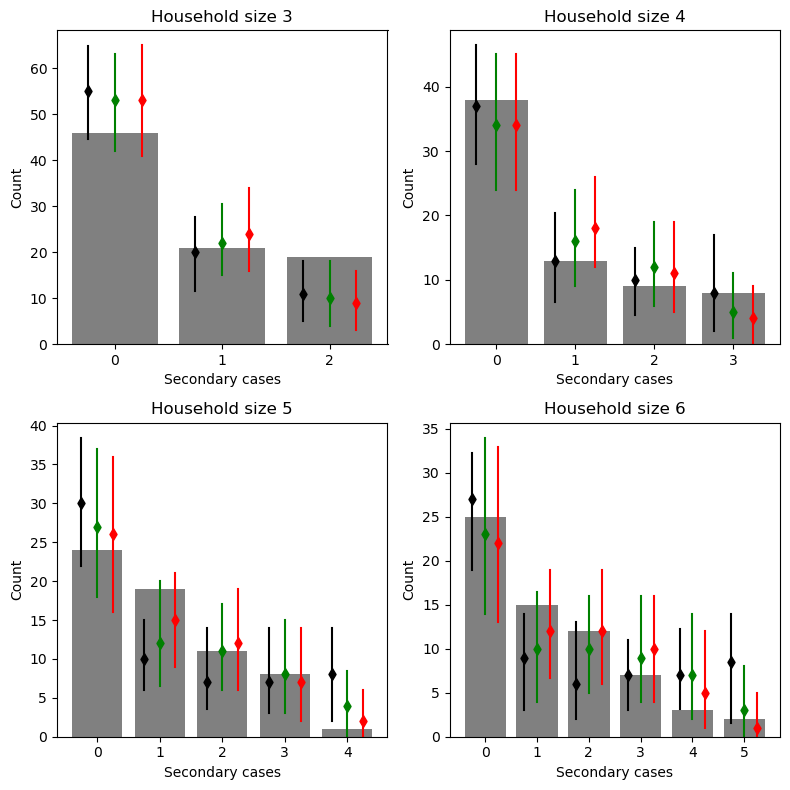

In [38]:
plt.figure(figsize=(8,8))
for i in range(1,5):
    plt.subplot(2,2,i)
    n = i+2
    xx = np.arange(0,n)
    yy = X[i,0:n]
    plt.bar(xx,yy,color='grey')  
    m = int(np.sum(yy))

    for j in range(0,3):
        for x in xx:
            plt.plot(x*np.ones(2)+0.25*(j-1), [Zl[j,i,x], Zu[j,i,x]], c=cols[j])
            plt.scatter(x*np.ones(1)+0.25*(j-1), Zm[j,i,x], marker='d', c=cols[j])

    plt.xticks(xx)
    plt.xlabel('Secondary cases')
    plt.ylabel('Count')
    plt.title('Household size ' + str(n))
plt.tight_layout()
plt.savefig('./hetfig.pdf')